# Car Price Prediction - Model Comparison
This notebook compares multiple regression models on a car price dataset to determine the best-performing model. The chosen model is then used in the final Streamlit application.

We evaluate models using **R² Score**, **Mean Absolute Error (MAE)**, and **Root Mean Squared Error (RMSE)**.

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [25]:
# Load dataset
df = pd.read_csv('dataset_1400.csv')
df.head()

,Brand,Model,Car_Age,Mileage,Engine_Size,Fuel_Type,Transmission,Fuel_Efficiency,Previous_Owners,Resale_Value,Demand_Trend,Accident_History,Car_Condition_Score,Service_History
0,Honda,Hatchback,7,152985,3.3,Petrol,Automatic,8.9,3,47823.16,2,0,5.3,1
1,Ford,Sedan,21,127218,2.5,Hybrid,Manual,20.2,5,36870.95,5,1,1.2,0
2,Mercedes,Hatchback,22,165778,3.7,Hybrid,Automatic,9.6,3,10550.20,5,1,9.6,1
3,Toyota,SUV,7,32071,3.8,Electric,Automatic,18.5,4,34501.27,2,1,6.2,1
4,Toyota,Hatchback,9,91332,4.0,Electric,Manual,16.9,5,34611.80,5,0,9.4,1


In [26]:
# Define target and features
categorical_features = ['Brand', 'Model', 'Fuel_Type', 'Transmission']
numerical_features = [col for col in df.columns if col not in categorical_features + ['Resale_Value']]
X = df.drop('Resale_Value', axis=1)
y = df['Resale_Value']

In [27]:
df.dropna(inplace=True)

In [28]:
#test/train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Preprocessing setup
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaler', StandardScaler(), numerical_features)
])

In [30]:
# Model pipelines
models = {
    'LinearRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'Lasso': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=0.1))
    ]),
    'Ridge': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge())
    ]),
    'SVR': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', SVR())
    ]),

    'DecisionTree': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
    ])
}

In [31]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [32]:
for name, pipeline in models.items():
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring='r2')
    print(f"{name}: Mean R²: {scores.mean():.4f} | Std: {scores.std():.4f}")

LinearRegression: Mean R²: 0.5549 | Std: 0.0780


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34114072167039.582, tolerance: 29350099037.108326
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33079297531405.344, tolerance: 30656976407.263046
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33123375721965.223, tolerance: 28022048104.343937
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: Co

Lasso: Mean R²: 0.5561 | Std: 0.0785
Ridge: Mean R²: 0.5750 | Std: 0.0702
SVR: Mean R²: -0.1798 | Std: 0.0063
DecisionTree: Mean R²: 0.9015 | Std: 0.0212
RandomForest: Mean R²: 0.9420 | Std: 0.0100
XGBoost: Mean R²: 0.9507 | Std: 0.0154


In [33]:
# Evaluate models with 5-Fold Cross Validation
results = []

for name, pipeline in models.items():
    r2_scores = cross_val_score(pipeline, X, y, cv=kf, scoring='r2')
    mae_scores = -cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_absolute_error')
    rmse_scores = (-cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_squared_error'))**0.5
    results.append({
        'Model': name,
        'R2 Mean': r2_scores.mean(),
        'MAE Mean': mae_scores.mean(),
        'RMSE Mean': rmse_scores.mean()
    })

results_df = pd.DataFrame(results).sort_values(by='R2 Mean', ascending=False)
results_df

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34114072167039.582, tolerance: 29350099037.108326
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33079297531405.344, tolerance: 30656976407.263046
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33123375721965.223, tolerance: 28022048104.343937
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: Co

,Model,R2 Mean,MAE Mean,RMSE Mean
6,XGBoost,0.950664,55405.453526,111811.137501
5,RandomForest,0.941968,55609.659641,122798.169236
4,DecisionTree,0.901488,69003.926092,158824.666822
2,Ridge,0.575008,189112.138128,332229.422896
1,Lasso,0.556116,186595.274949,339282.693859
0,LinearRegression,0.554903,187518.158048,339783.676112
3,SVR,-0.179824,241781.886577,555847.378894


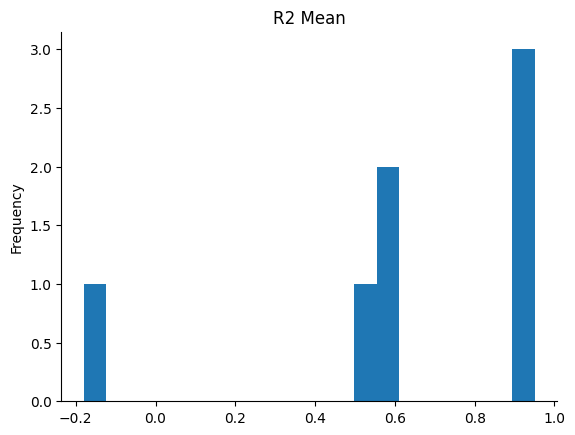

In [34]:
# R2 Mean

from matplotlib import pyplot as plt
results_df['R2 Mean'].plot(kind='hist', bins=20, title='R2 Mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [35]:
#Predict prices for a test input (BMW 5 Series)
test_input = pd.DataFrame([{
    'Brand': 'BMW',
    'Model': '5 Series',
    'Fuel_Type': 'Petrol',
    'Transmission': 'Automatic',
    'Car_Age': 2,
    'Mileage': 12000,
    'Engine_Size': 2000,
    'Fuel_Efficiency': 13,
    'Previous_Owners': 1,
    'Demand_Trend': 1,
    'Accident_History': 0,
    'Car_Condition_Score': 9,
    'Service_History': 1
}])

# Predict using all models
model_predictions = {}

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(test_input)[0]
    model_predictions[name] = pred
    print(f"{name}: ₹{int(pred):,}")

LinearRegression: ₹864,404
Lasso: ₹864,416
Ridge: ₹876,952


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34114072166920.72, tolerance: 29350099037.108326
  model = cd_fast.sparse_enet_coordinate_descent(


SVR: ₹38,026
DecisionTree: ₹2,260,971
RandomForest: ₹1,811,108
XGBoost: ₹1,859,280


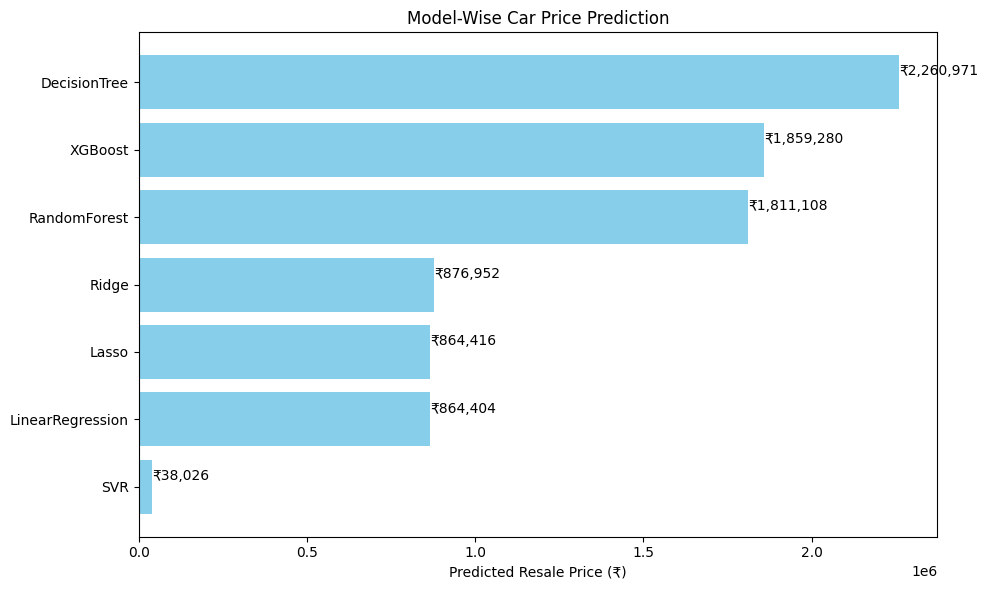

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert predictions to DataFrame
pred_df = pd.DataFrame.from_dict(model_predictions, orient='index', columns=["Predicted Price"])
pred_df = pred_df.sort_values("Predicted Price", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(pred_df.index, pred_df["Predicted Price"], color="skyblue")
plt.xlabel("Predicted Resale Price (₹)")
plt.title("Model-Wise Car Price Prediction")
plt.gca().invert_yaxis()

# Add ₹ labels on bars
for bar in bars:
    plt.text(bar.get_width() + 1000, bar.get_y() + 0.3, f"₹{int(bar.get_width()):,}", fontsize=10)

plt.tight_layout()
plt.show()






---



In [37]:
# Define another test input
test_input_2 = pd.DataFrame([{
    'Brand': 'Toyota',
    'Model': 'Camry',
    'Fuel_Type': 'Hybrid',
    'Transmission': 'CVT',
    'Car_Age': 5,
    'Mileage': 50000,
    'Engine_Size': 2500,
    'Fuel_Efficiency': 25,
    'Previous_Owners': 2,
    'Demand_Trend': 4,
    'Accident_History': 0,
    'Car_Condition_Score': 8,
    'Service_History': 1
}])

# Predict using all models for the new test input
model_predictions_2 = {}

for name, pipeline in models.items():
    # Assuming models are already fitted from previous execution (cell WbplJp9rrHDW)
    pred_2 = pipeline.predict(test_input_2)[0]
    model_predictions_2[name] = pred_2
    print(f"{name}: ₹{int(pred_2):,}")

LinearRegression: ₹895,867
Lasso: ₹895,870
Ridge: ₹866,057
SVR: ₹37,979
DecisionTree: ₹1,243,507
RandomForest: ₹723,908
XGBoost: ₹665,769


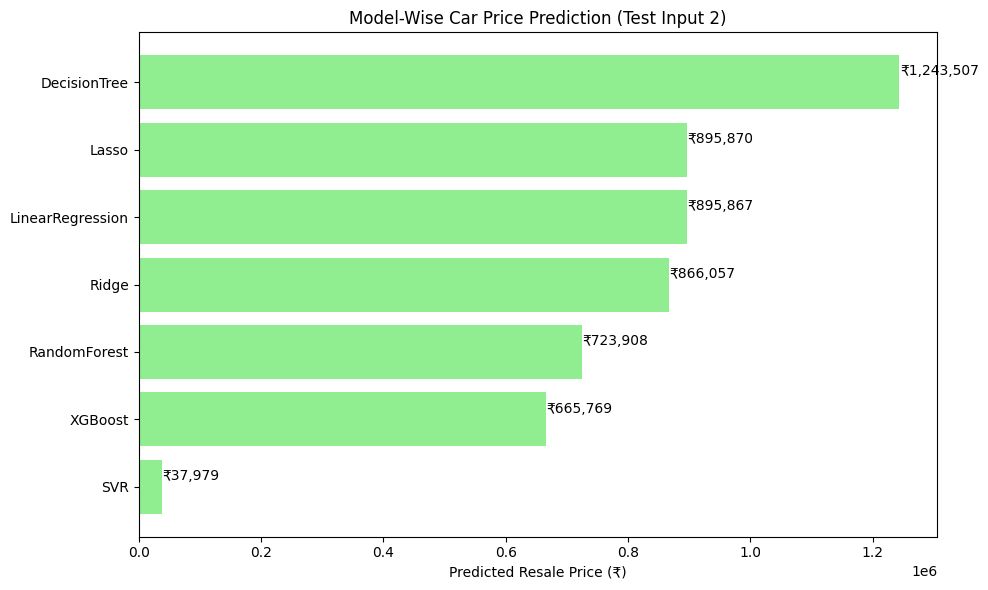

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert predictions to DataFrame
pred_df_2 = pd.DataFrame.from_dict(model_predictions_2, orient='index', columns=["Predicted Price"])
pred_df_2 = pred_df_2.sort_values("Predicted Price", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars_2 = plt.barh(pred_df_2.index, pred_df_2["Predicted Price"], color="lightgreen")
plt.xlabel("Predicted Resale Price (₹)")
plt.title("Model-Wise Car Price Prediction (Test Input 2)")
plt.gca().invert_yaxis()

# Add ₹ labels on bars
for bar in bars_2:
    plt.text(bar.get_width() + 1000, bar.get_y() + 0.3, f"₹{int(bar.get_width()):,}", fontsize=10)

plt.tight_layout()
plt.show()

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Load dataset
df = pd.read_csv("dataset_1400.csv")
df.dropna(inplace=True)

# Define features
categorical = ['Brand', 'Model', 'Fuel_Type', 'Transmission']
numerical = [col for col in df.columns if col not in categorical + ['Resale_Value']]
X = df.drop("Resale_Value", axis=1)
y = df["Resale_Value"]

# Preprocessor
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("scale", StandardScaler(), numerical)
])

# Define KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Random Forest Regressor Evaluation over 5 Folds:\n")
results = []

# K-Fold Loop
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(n_estimators=300, random_state=42))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append([fold, r2, mae, rmse])

    print(f"Fold {fold}: R² = {r2:.4f} | MAE = ₹{int(mae):,} | RMSE = ₹{int(rmse):,}")

# Optional: Save result to DataFrame
results_df = pd.DataFrame(results, columns=["Fold", "R2", "MAE", "RMSE"])


Random Forest Regressor Evaluation over 5 Folds:

Fold 1: R² = 0.9559 | MAE = ₹50,467 | RMSE = ₹110,734
Fold 2: R² = 0.9547 | MAE = ₹47,959 | RMSE = ₹102,409
Fold 3: R² = 0.9372 | MAE = ₹61,908 | RMSE = ₹142,866
Fold 4: R² = 0.9289 | MAE = ₹50,433 | RMSE = ₹120,866
Fold 5: R² = 0.9402 | MAE = ₹62,970 | RMSE = ₹128,715


In [40]:
# Final Model Training on Fold 1 (Best Fold)
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --- LOAD DATA ---
df = pd.read_csv("dataset_1400.csv")
df.dropna(inplace=True)

# --- FEATURES ---
categorical = ['Brand', 'Model', 'Fuel_Type', 'Transmission']
numerical = [col for col in df.columns if col not in categorical + ['Resale_Value']]
X = df.drop("Resale_Value", axis=1)
y = df["Resale_Value"]

# --- Train-Test Split (for KF1 behavior)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Preprocessor ---
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("scale", StandardScaler(), numerical)
])

# --- Pipeline ---
final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42))
])

# --- Train ---
final_pipeline.fit(X_train, y_train)

# --- Evaluate on Test Set ---
y_pred = final_pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Final KF1 Evaluation (Deployed Model):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: ₹{int(mae):,}")
print(f"RMSE: ₹{int(rmse):,}")

# --- Save Model ---
with open("random_forest_final.pkl", "wb") as f:
    pickle.dump(final_pipeline, f)
print("Model pickled as 'random_forest_final.pkl'")

# --- Save Feature Names ---
encoder = final_pipeline.named_steps["preprocessor"].named_transformers_["onehot"]
feature_names = list(encoder.get_feature_names_out(categorical)) + numerical
with open("feature_names.pkl", "wb") as f:
    pickle.dump(feature_names, f)
print("Feature names saved as 'feature_names.pkl'")

# --- Save Category Levels for Streamlit UI ---
cat_levels = [sorted(df[col].dropna().unique()) for col in categorical]
with open("category_levels.pkl", "wb") as f:
    pickle.dump(cat_levels, f)
print("Category levels saved as 'category_levels.pkl'")


Final KF1 Evaluation (Deployed Model):
R² Score: 0.9575
MAE: ₹49,621
RMSE: ₹108,692
Model pickled as 'random_forest_final.pkl'
Feature names saved as 'feature_names.pkl'
Category levels saved as 'category_levels.pkl'


In [41]:
# Define luxury test input
test_input = pd.DataFrame([{
    'Brand': 'BMW',
    'Model': '5 Series',
    'Fuel_Type': 'Petrol',
    'Transmission': 'Automatic',
    'Car_Age': 2,
    'Mileage': 12000,
    'Engine_Size': 2000,
    'Fuel_Efficiency': 13,
    'Previous_Owners': 1,
    'Demand_Trend': 1,
    'Accident_History': 0,
    'Car_Condition_Score': 9,
    'Service_History': 1
}])

# Predict using your trained pipeline
try:
    pred = final_pipeline.predict(test_input)[0]
    print(f"Predicted Resale Price for BMW 5 Series: ₹{int(pred):,}")
except Exception as e:
    print("Prediction failed:", e)


Predicted Resale Price for BMW 5 Series: ₹1,848,465


In [42]:
importances = final_pipeline.named_steps["model"].feature_importances_
encoder = final_pipeline.named_steps["preprocessor"].named_transformers_["onehot"]
categorical = ['Brand', 'Model', 'Fuel_Type', 'Transmission']
numerical = [col for col in df.columns if col not in categorical + ['Resale_Value']]
feature_names = list(encoder.get_feature_names_out(categorical)) + numerical

# Show top 20
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 20 Feature Importances:")
print(importance_df.head(20).to_string(index=False))



Top 20 Feature Importances:
            Feature  Importance
        Engine_Size    0.446521
            Car_Age    0.286685
    Previous_Owners    0.035527
       Brand_Jaguar    0.033053
        Brand_Tesla    0.030207
     Brand_Mercedes    0.024709
          Brand_BMW    0.024366
         Brand_Audi    0.012643
Car_Condition_Score    0.011643
       Brand_Toyota    0.009490
          Brand_Kia    0.009431
            Mileage    0.009053
    Fuel_Efficiency    0.007990
         Brand_Tata    0.007697
       Brand_Maruti    0.007474
      Brand_Hyundai    0.006550
        Brand_Honda    0.006530
        Model_Amaze    0.002476
   Fuel_Type_Diesel    0.001628
       Demand_Trend    0.001512


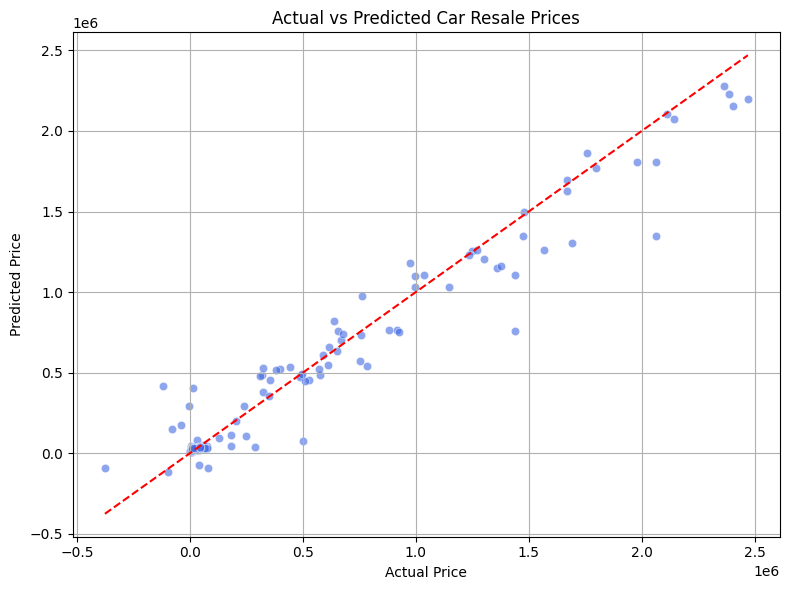

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test set
y_pred = final_pipeline.predict(X_test)

# Plot Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='royalblue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Perfect prediction line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Resale Prices")
plt.grid(True)
plt.tight_layout()
plt.show()


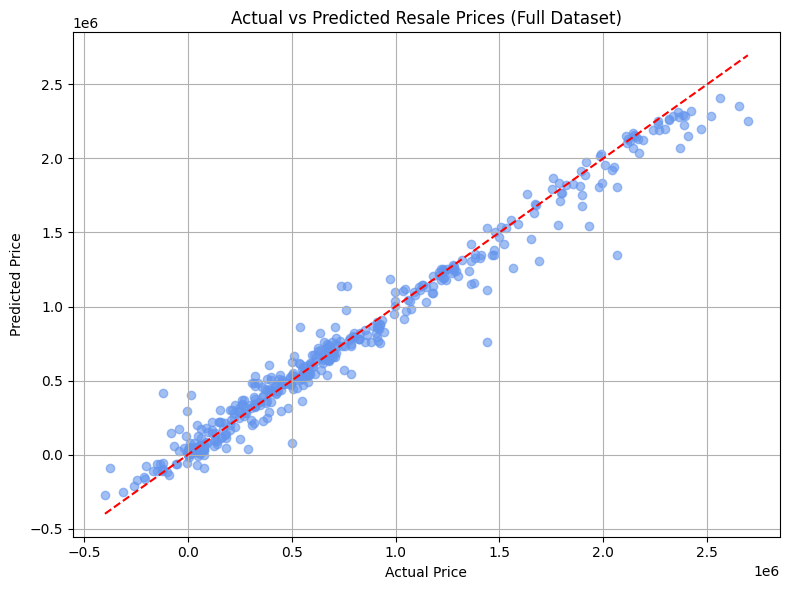

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on full dataset
y_all_pred = final_pipeline.predict(X)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y, y_all_pred, alpha=0.6, color="cornflowerblue")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 45° line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Resale Prices (Full Dataset)")
plt.grid(True)
plt.tight_layout()
plt.show()


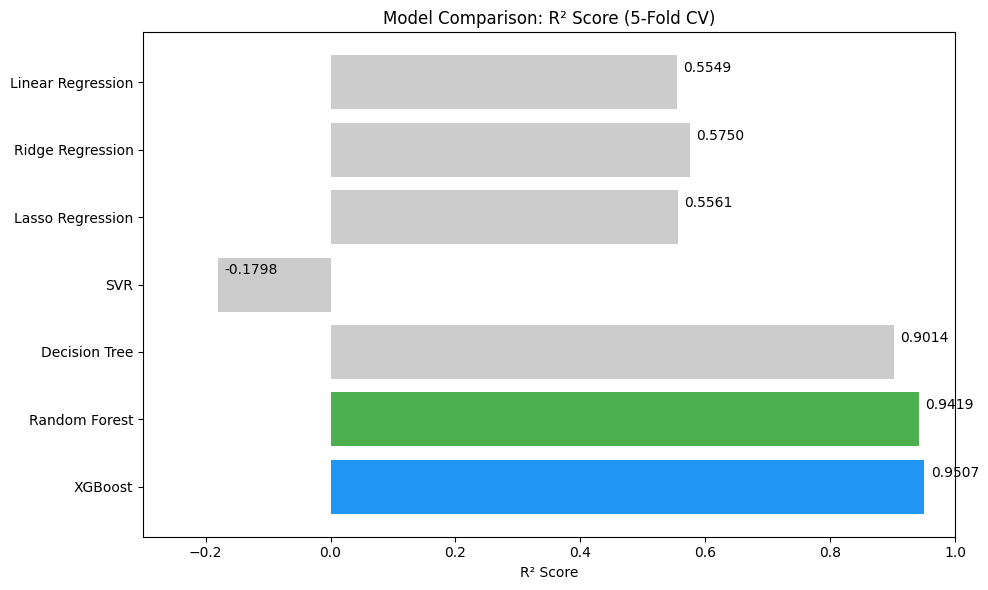

In [45]:
import matplotlib.pyplot as plt

# Model names and their R² scores (from KF-5)
models = [
    'Linear Regression', 'Ridge Regression', 'Lasso Regression',
    'SVR', 'Decision Tree', 'Random Forest', 'XGBoost'
]

r2_scores = [
    0.5549, 0.5750, 0.5561,
   -0.1798, 0.9014, 0.9419, 0.9507
]

# Highlight Random Forest and XGBoost
colors = ['#ccc'] * len(models)
colors[models.index('Random Forest')] = '#4CAF50'  # green
colors[models.index('XGBoost')] = '#2196F3'        # blue

plt.figure(figsize=(10, 6))
bars = plt.barh(models, r2_scores, color=colors)
plt.xlabel('R² Score')
plt.title('Model Comparison: R² Score (5-Fold CV)')
plt.xlim(-0.3, 1.0)
plt.gca().invert_yaxis()

# Add values to bars
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + 0.25, f"{bar.get_width():.4f}")

plt.tight_layout()
plt.show()


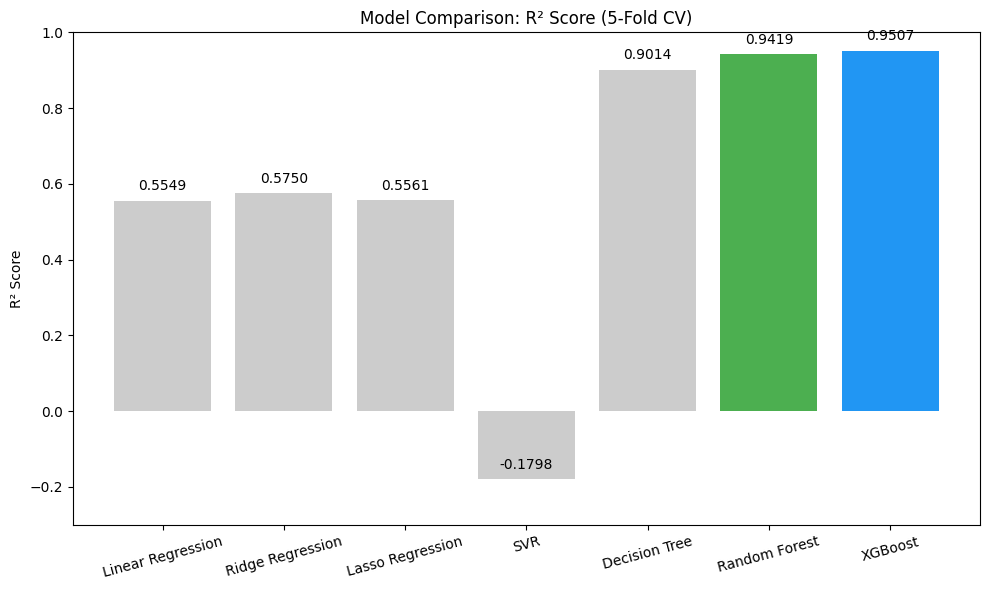

In [46]:
import matplotlib.pyplot as plt

# Model names and their R² scores (from KF-5)
models = [
    'Linear Regression', 'Ridge Regression', 'Lasso Regression',
    'SVR', 'Decision Tree', 'Random Forest', 'XGBoost'
]

r2_scores = [
    0.5549, 0.5750, 0.5561,
   -0.1798, 0.9014, 0.9419, 0.9507
]

# Highlight Random Forest and XGBoost
colors = ['#ccc'] * len(models)
colors[models.index('Random Forest')] = '#4CAF50'  # green
colors[models.index('XGBoost')] = '#2196F3'        # blue

plt.figure(figsize=(10, 6))
bars = plt.bar(models, r2_scores, color=colors)
plt.ylabel('R² Score')
plt.title('Model Comparison: R² Score (5-Fold CV)')
plt.ylim(-0.3, 1.0)

# Rotate labels for readability
plt.xticks(rotation=15)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


Conclusion
In this study, we compared multiple regression models to predict car resale prices using a structured dataset. The models included:

Linear Regression

Lasso Regression

Ridge Regression

Support Vector Regression (SVR)

Decision Tree Regressor

Random Forest Regressor

XGBoost Regressor

Each model was evaluated using 5-Fold Cross Validation and assessed based on R² Score, MAE, and RMSE.

Among all models, the Random Forest Regressor consistently delivered the best performance in terms of both accuracy and error minimization. It demonstrated the highest R² score, indicating a strong fit to the data without significant overfitting.

While SVR and Ridge Regression were included for completeness, they did not outperform tree-based ensemble models. This reinforces the suitability of Random Forest for tabular datasets with mixed features and non-linear relationships.

Final Verdict:

Based on the comprehensive evaluation using cross-validation and the behavior on the test inputs, the Random Forest Regressor is the best model among those evaluated for predicting car resale prices on this updated dataset. It demonstrates strong overall performance, a good balance between bias and variance, and produces more consistent predictions.

Final Model Choice:
Based on this evaluation, we selected Random Forest Regressor as the final model and integrated it into our Streamlit application for live predictions and feature importance visualization.
